In [1]:
import numpy 
import os
import ast
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.examples.utils_example import (
    wavg,
    collapse,
    dataframe_by_group,
    graph_builder_bar,
    df_weighted_average_grouped)
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy
from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile

from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Reform_carbon_tax import carbon_tax_rv
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Simulation_taxe_energie_winners_losers import (
    simulate_reformes_energie,
    run_all_elasticities,
    graph_winners_losers,
    graph_net_transfers,
    graph_effort_rate,
    quantiles_for_boxplot,
    boxplot_effort_rate,
    boxplot_net_transfers
    )

In [2]:
data_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data"
output_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Output"
elasticite = True
replique_gouv = True
sns.set_style("whitegrid")

In [3]:
df_elasticities = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_literature.csv'), sep = ";")
df_elasticities = df_elasticities.astype({'ref_elasticity': str, 'elas_price_1_1': float , 'elas_price_2_2' : float ,'elas_price_3_3' : float })

# exemple
elasticites_douenne = df_elasticities[df_elasticities['ref_elasticity'] == 'Douenne (2020)'] 

In [4]:
to_graph, menages_reform = run_all_elasticities(df_elasticities, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)

In [5]:
menages_reform.to_csv(os.path.join(output_path,'Data/menages_reform.csv'))
to_graph.to_csv(os.path.join(output_path,'Data/to_graph.csv'))

In [4]:
menages_reform = pd.read_csv(os.path.join(output_path,'Data/menages_reform.csv'), index_col = 0)
to_graph = pd.read_csv(os.path.join(output_path,'Data/to_graph.csv'), index_col = 0)

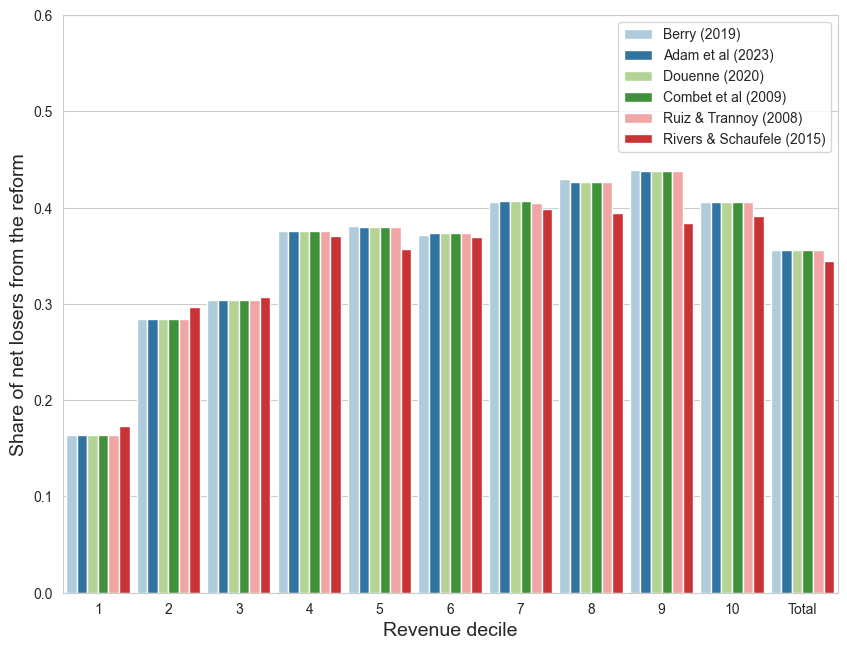

In [7]:
graph_winners_losers(to_graph,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Simulation_taxe_energie_winners_losers.py:254: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data = quantiles_to_plot , x='niveau_vie_decile', y='Net_transfers_reform', hue = 'ref_elasticity',


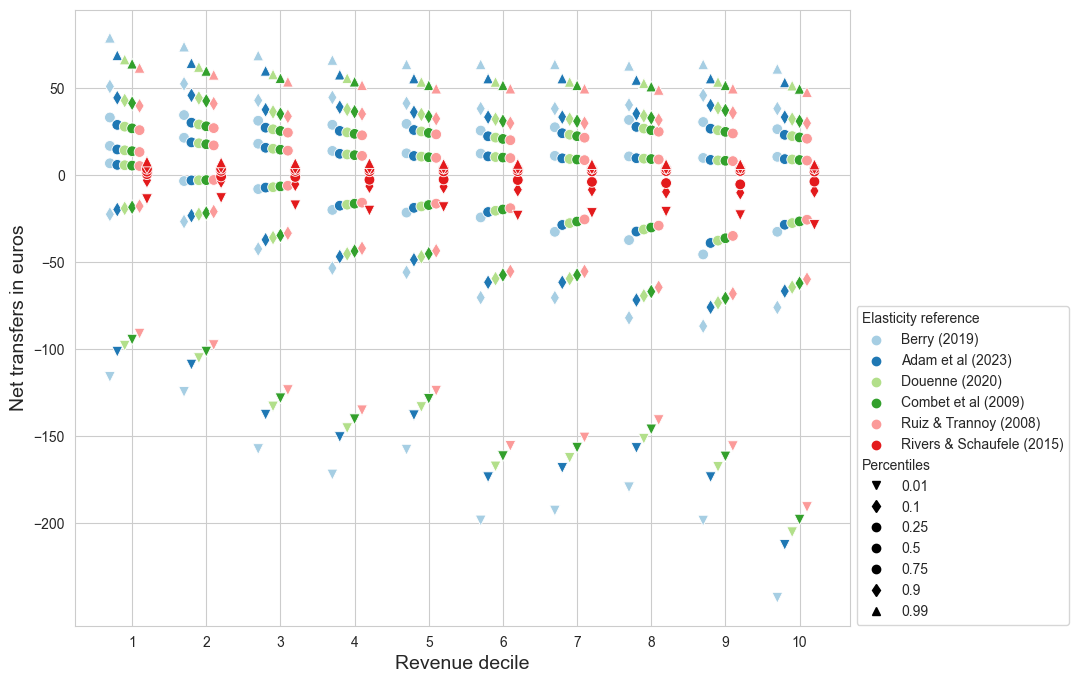

In [5]:
boxplot_net_transfers(menages_reform, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=True)

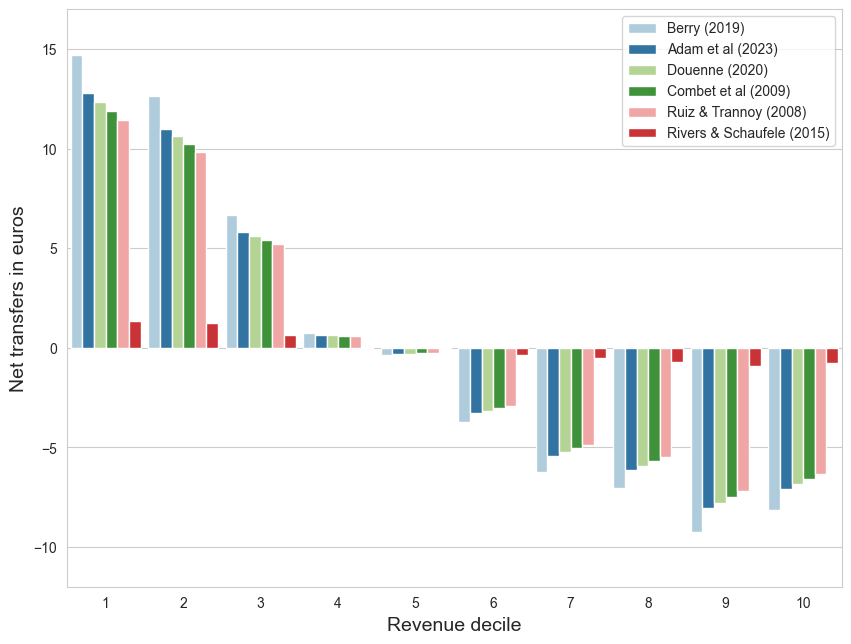

In [9]:
graph_net_transfers(to_graph,carbon_tax_rv,elas_vect = False,bonus_cheques_uc=True)

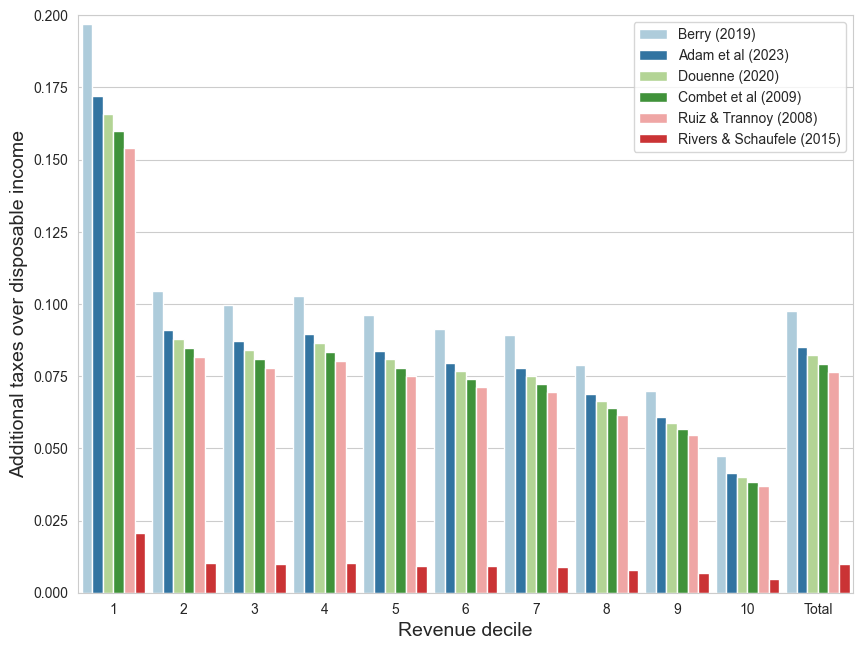

In [12]:
graph_effort_rate(to_graph,carbon_tax_rv,elas_vect = False,bonus_cheques_uc=True)

c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Simulation_taxe_energie_winners_losers.py:282: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data = quantiles_to_plot, x='niveau_vie_decile', y='Effort_rate', hue = 'ref_elasticity',


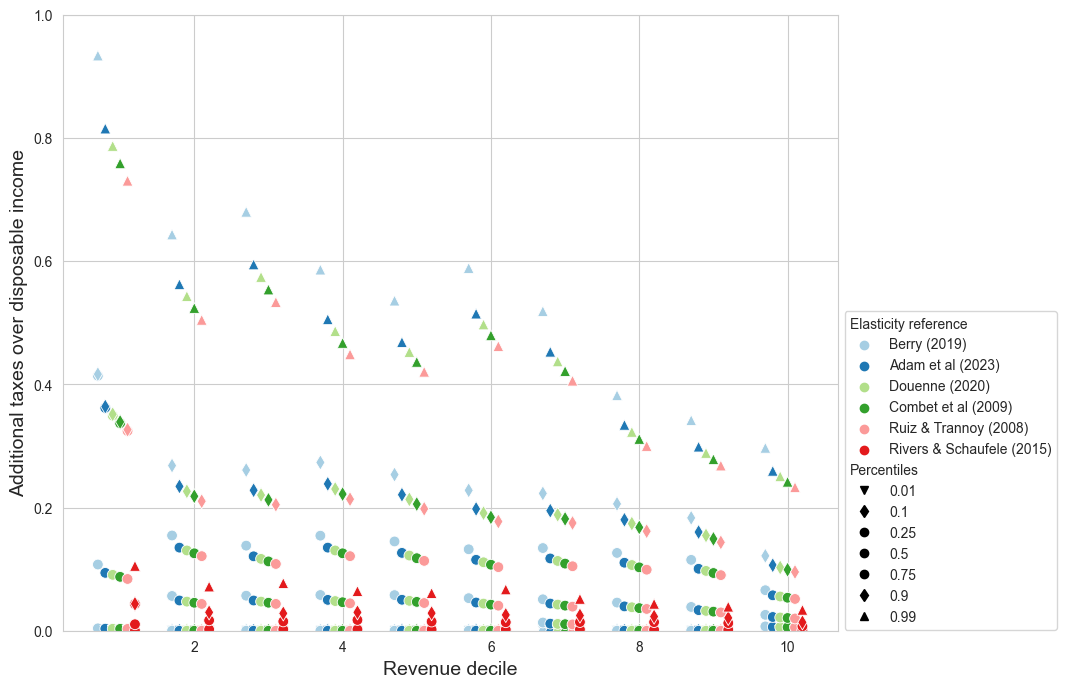

In [5]:
boxplot_effort_rate(menages_reform,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=True)

In [6]:
quantile_effort_rate = quantiles_for_boxplot(menages_reform,'Effort_rate')
quantile_effort_rate[quantile_effort_rate['ref_elasticity'] == 'Adam et al (2023)'].tail(10)

,niveau_vie_decile,ref_elasticity,Effort_rate,quantile
0,8.8,Adam et al (2023),0.100564,0.75
0,8.8,Adam et al (2023),0.160150,0.90
0,8.8,Adam et al (2023),0.298826,0.99
0,9.8,Adam et al (2023),0.000000,0.01
0,9.8,Adam et al (2023),0.000000,0.10
0,9.8,Adam et al (2023),0.006050,0.25
0,9.8,Adam et al (2023),0.022291,0.50
0,9.8,Adam et al (2023),0.057492,0.75
0,9.8,Adam et al (2023),0.106273,0.90
0,9.8,Adam et al (2023),0.259585,0.99


In [8]:
df_elas_vect = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_Douenne_20.csv'), index_col = [0])
df_elas_vect = pd.melt(frame = df_elas_vect , id_vars = ["niveau_vie_decile",'ref_elasticity'], var_name = 'strate_2', value_name = 'elas_price_1_1')

In [10]:
to_graph_douenne_scal, menages_reform_douenne_scal = simulate_reformes_energie(elas_vect = True, elasticites = df_elas_vect, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
to_graph_douenne_vect, menages_reform_douenne_vect = simulate_reformes_energie(elas_vect = False, elasticites = elasticites_douenne, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
to_graph_douenne_only = pd.concat([to_graph_douenne_scal, to_graph_douenne_vect])
menages_reform_douenne_only = pd.concat([menages_reform_douenne_scal, menages_reform_douenne_vect])

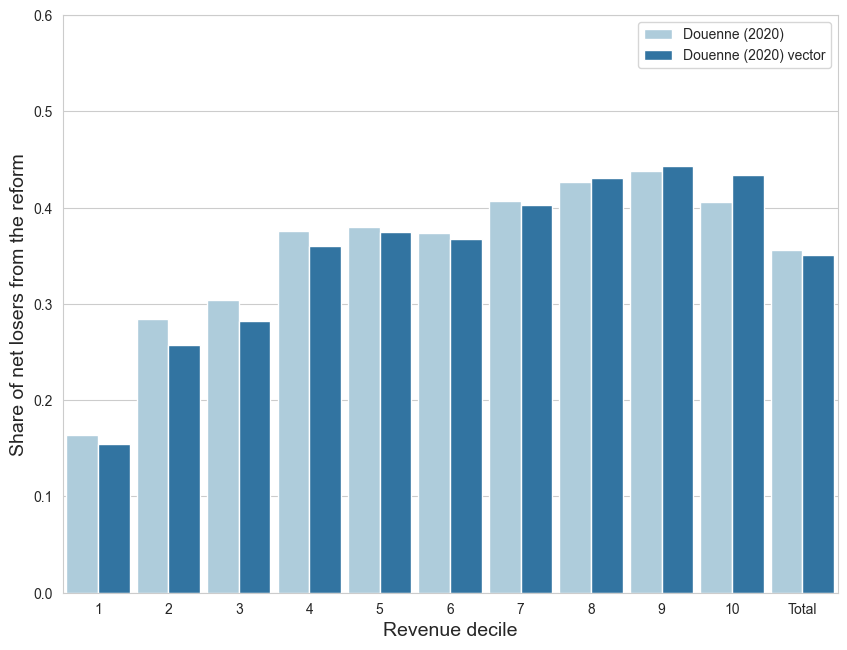

In [18]:
graph_winners_losers(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

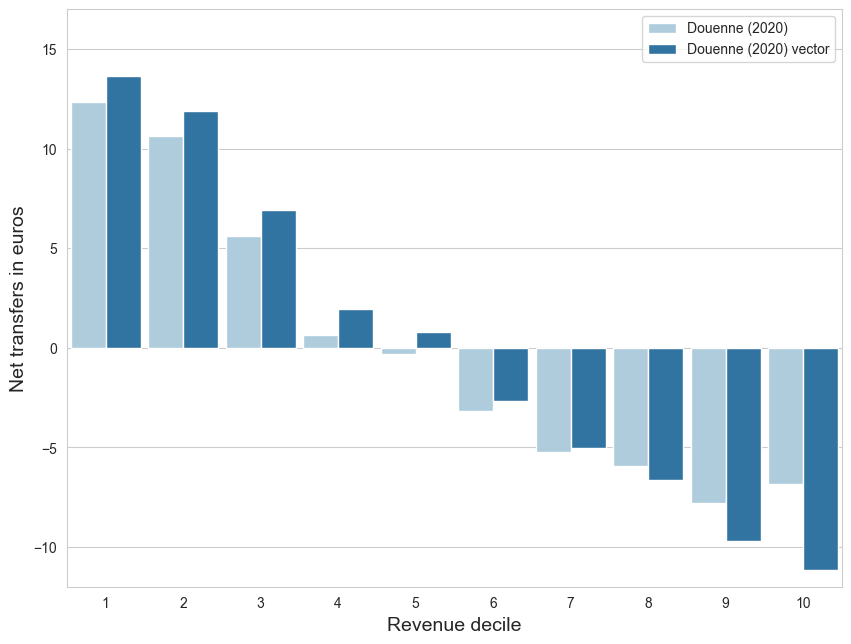

In [19]:
graph_net_transfers(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

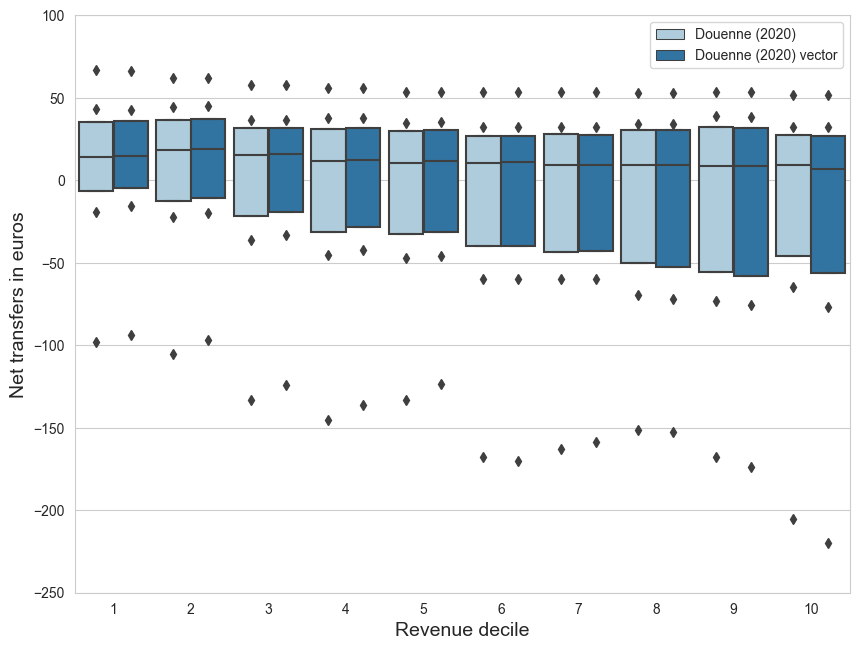

In [11]:
boxplot_net_transfers(menages_reform_douenne_only, carbon_tax_rv, elas_vect=True, bonus_cheques_uc=True)

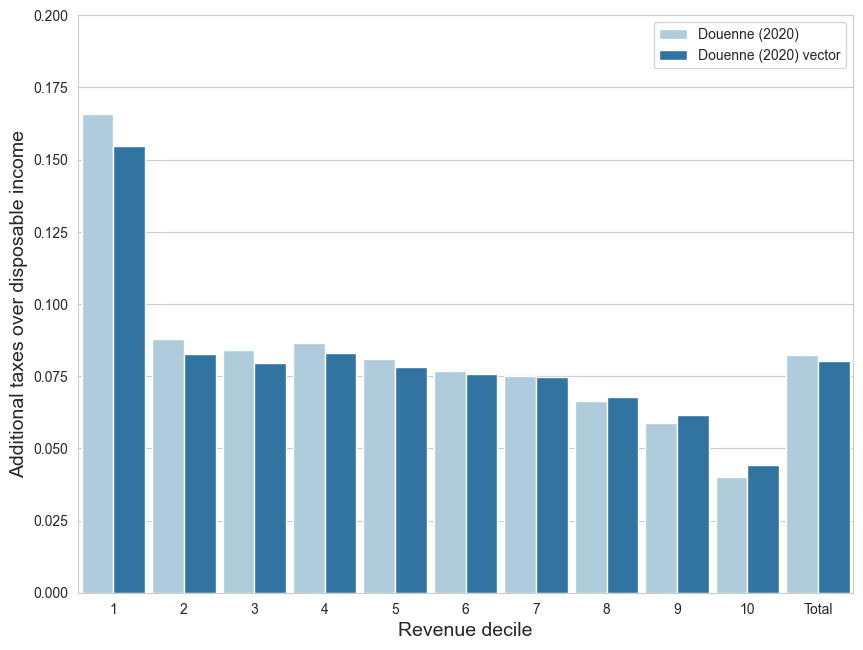

In [21]:
graph_effort_rate(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

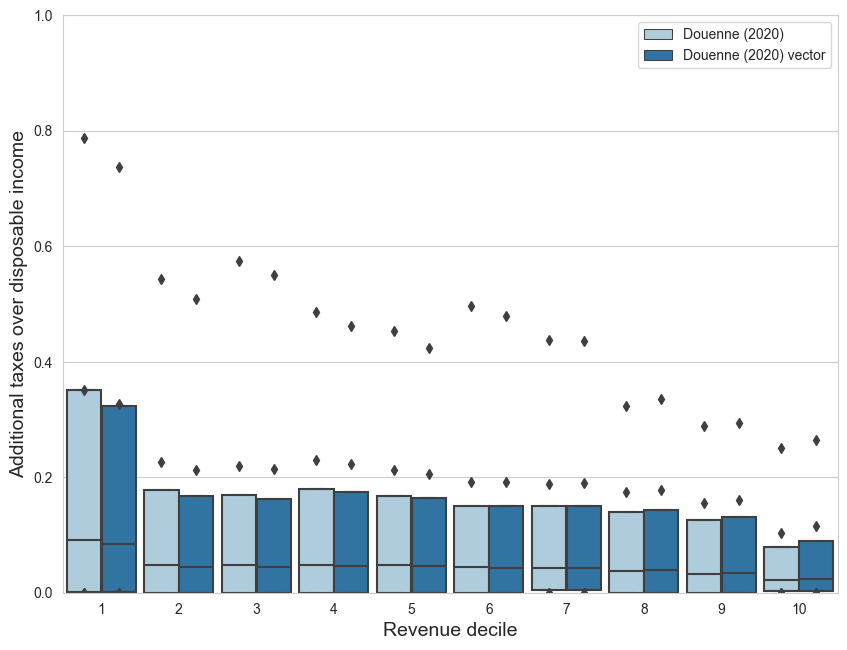

In [12]:
boxplot_effort_rate(menages_reform_douenne_only, carbon_tax_rv, elas_vect=True, bonus_cheques_uc=True)

In [13]:
to_graph_menage, menages_reform_menage = run_all_elasticities(data_elasticities = df_elasticities, year = 2019, reform = carbon_tax_rv, bonus_cheques_uc= False)

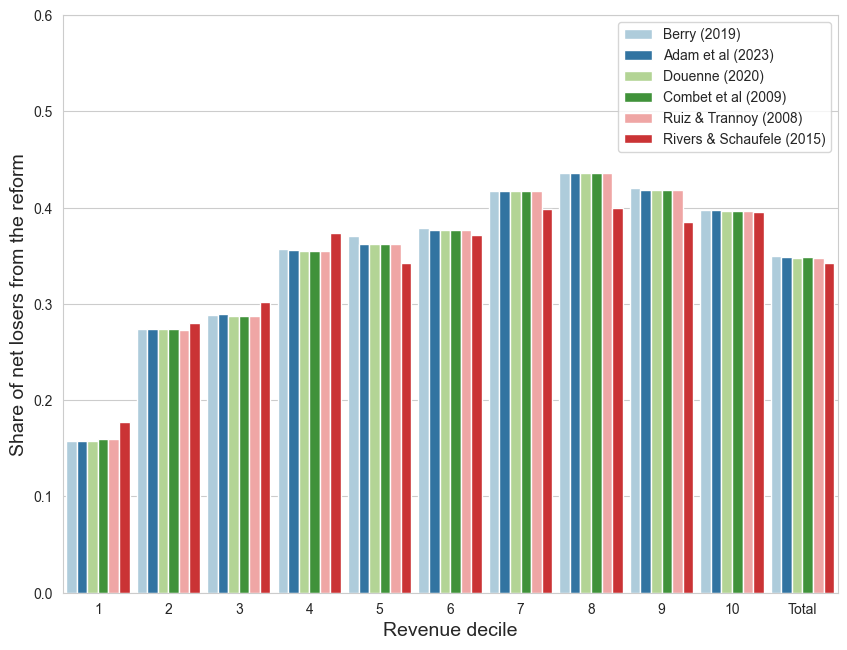

In [24]:
graph_winners_losers(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

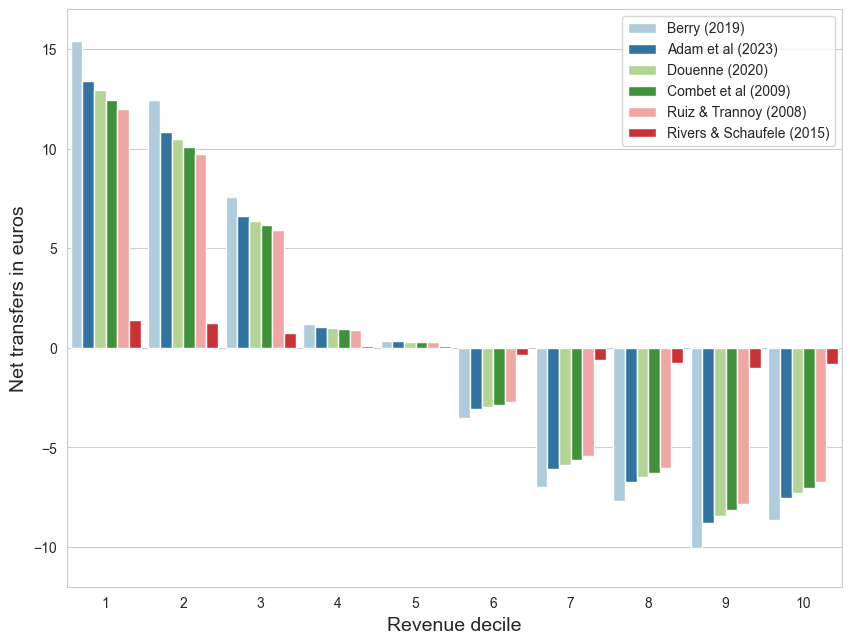

In [25]:
graph_net_transfers(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

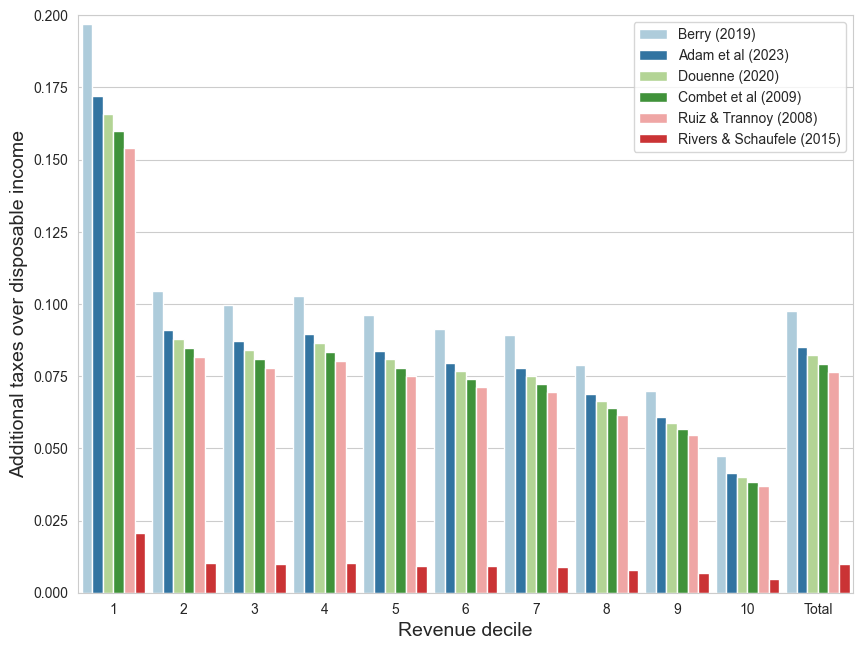

In [26]:
graph_effort_rate(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

## A creuser !

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

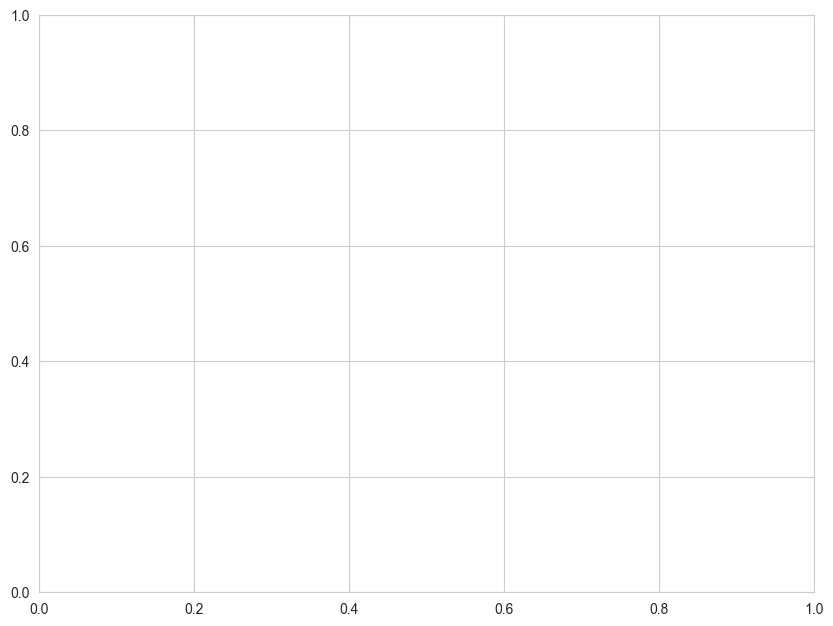

In [27]:
boxplot_net_transfers(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\veve1\OneDrive\Documents\ENSAE 3A\Memoire MiE\hervenv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\veve1\AppData\Local\Temp\ipykernel_19344\3670938973.py", line 1, in <module>
    boxplot_effort_rate(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)
  File "c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Simulation_taxe_energie_winners_losers.py", line 223, in boxplot_effort_rate
  File "c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Simulation_taxe_energie_winners_losers.py", line 196, in quantiles_for_boxplot
    for q in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]:
  File "c:\Users\veve1\OneDrive\D

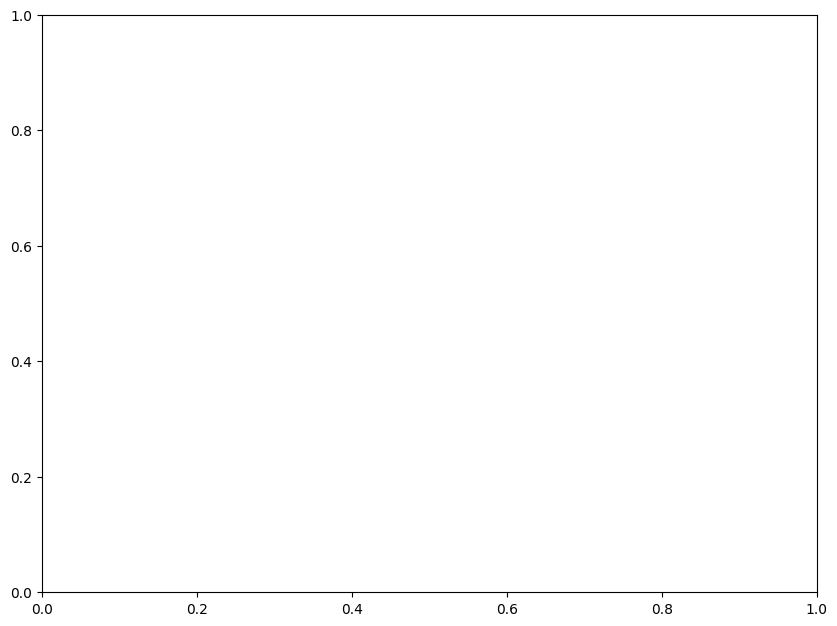

In [ ]:
boxplot_effort_rate(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)